# Susceptibility to substitution

## 1 Setup

Flags and settings.

In [1]:
SAVE_FIGURES = False
PAPER_FEATURES = ['frequency', 'aoa', 'clustering', 'letters_count', 'synonyms_count',
                  'orthographic_density']
BIN_COUNT = 4

Imports and database setup.

In [2]:
import pandas as pd
import seaborn as sb
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from progressbar import ProgressBar
from statsmodels.stats.proportion import multinomial_proportions_confint

%cd -q ..
from brainscopypaste.conf import settings
%cd -q notebooks
from brainscopypaste.mine import Model, Time, Source, Past, Durl
from brainscopypaste.db import Substitution
from brainscopypaste.utils import init_db, session_scope, stopwords
engine = init_db()

## 2 Susceptibility in absolute and sentence-relative values

Build our data.

In [3]:
model = Model(time=Time.discrete, source=Source.all, past=Past.all, durl=Durl.exclude_past, max_distance=1)
data = []

with session_scope() as session:
    substitutions = session.query(Substitution.id).filter(Substitution.model == model)
    print("Got {} substitutions for model {}".format(substitutions.count(), model))
    substitution_ids = [id for (id,) in substitutions]

for substitution_id in ProgressBar(term_width=80)(substitution_ids):
    with session_scope() as session:
        substitution = session.query(Substitution).get(substitution_id)
        # Prepare these arrays for stopword-checking.
        dslice = slice(substitution.start,
                       substitution.start + len(substitution.destination.tokens))
        lemmas = substitution.source.lemmas[dslice]
        tokens = substitution.source.tokens[dslice]
        tags = substitution.source.tags[dslice]
        
        for feature in Substitution.__features__:
            sentence_values, _ = substitution.source_destination_features(feature)
            sentence_values_rel, _ = substitution.source_destination_features(
                feature, sentence_relative='median')
            source_type, _ = Substitution.__features__[feature]
            # Stopword-check the arrays.
            words = getattr(substitution.source, source_type)[dslice]
            for i, (word, lemma, token, tag) in enumerate(zip(words, lemmas, tokens, tags)):
                if (token in stopwords) or (lemma in stopwords):
                    # Drop stopwords from this analysis since we exclude stopword-substitutions.
                    continue
                data.append({'cluster_id': substitution.source.cluster.sid,
                             'destination_id': substitution.destination.sid,
                             'occurrence': substitution.occurrence,
                             'source_id': substitution.source.sid,
                             'feature': feature,
                             'word': word,
                             'POS': tag,
                             'target': i == substitution.position,
                             'value': sentence_values[i],
                             'value_rel': sentence_values_rel[i]})

original_susties = pd.DataFrame(data)
del data

Got 15119 substitutions for model Model(time=Time.discrete, source=Source.all, past=Past.all, durl=Durl.exclude_past, max_distance=1)


  0% (    1 of 15119) |                   | Elapsed Time: 0:00:04 ETA:  17:28:08

  0% (   67 of 15119) |                    | Elapsed Time: 0:00:05 ETA:  0:03:44

  1% (  189 of 15119) |                    | Elapsed Time: 0:00:06 ETA:  0:02:40

  1% (  283 of 15119) |                    | Elapsed Time: 0:00:07 ETA:  0:02:37

  2% (  378 of 15119) |                    | Elapsed Time: 0:00:08 ETA:  0:02:40

  3% (  475 of 15119) |                    | Elapsed Time: 0:00:09 ETA:  0:02:36

  3% (  567 of 15119) |                    | Elapsed Time: 0:00:10 ETA:  0:02:33

  4% (  669 of 15119) |                    | Elapsed Time: 0:00:11 ETA:  0:02:30

  5% (  756 of 15119) |#                   | Elapsed Time: 0:00:12 ETA:  0:02:19

  5% (  869 of 15119) |#                   | Elapsed Time: 0:00:13 ETA:  0:02:18

  6% (  945 of 15119) |#                   | Elapsed Time: 0:00:13 ETA:  0:02:16

  7% ( 1061 of 15119) |#                   | Elapsed Time: 0:00:14 ETA:  0:02:11

  7% ( 1134 of 15119) |#                   | Elapsed Time: 0:00:15 ETA:  0:02:07

  8% ( 1231 of 15119) |#                   | Elapsed Time: 0:00:16 ETA:  0:02:07

  8% ( 1323 of 15119) |#                   | Elapsed Time: 0:00:17 ETA:  0:02:06

  9% ( 1417 of 15119) |#                   | Elapsed Time: 0:00:18 ETA:  0:02:06

 10% ( 1512 of 15119) |##                  | Elapsed Time: 0:00:19 ETA:  0:02:07

 10% ( 1609 of 15119) |##                  | Elapsed Time: 0:00:20 ETA:  0:02:08

 11% ( 1701 of 15119) |##                  | Elapsed Time: 0:00:21 ETA:  0:02:11

 11% ( 1755 of 15119) |##                  | Elapsed Time: 0:00:22 ETA:  0:02:20

 12% ( 1848 of 15119) |##                  | Elapsed Time: 0:00:23 ETA:  0:02:23

 12% ( 1890 of 15119) |##                  | Elapsed Time: 0:00:23 ETA:  0:02:24

 13% ( 1992 of 15119) |##                  | Elapsed Time: 0:00:24 ETA:  0:02:22

 13% ( 2079 of 15119) |##                  | Elapsed Time: 0:00:25 ETA:  0:02:22

 14% ( 2170 of 15119) |##                  | Elapsed Time: 0:00:26 ETA:  0:02:22

 15% ( 2268 of 15119) |###                 | Elapsed Time: 0:00:27 ETA:  0:02:19

 15% ( 2364 of 15119) |###                 | Elapsed Time: 0:00:28 ETA:  0:02:18

 16% ( 2457 of 15119) |###                 | Elapsed Time: 0:00:29 ETA:  0:02:17

 16% ( 2563 of 15119) |###                 | Elapsed Time: 0:00:30 ETA:  0:02:05

 17% ( 2646 of 15119) |###                 | Elapsed Time: 0:00:31 ETA:  0:02:03

 18% ( 2733 of 15119) |###                 | Elapsed Time: 0:00:32 ETA:  0:02:04

 18% ( 2835 of 15119) |###                 | Elapsed Time: 0:00:33 ETA:  0:02:02

 19% ( 2952 of 15119) |###                 | Elapsed Time: 0:00:34 ETA:  0:01:56

 20% ( 3024 of 15119) |####                | Elapsed Time: 0:00:35 ETA:  0:01:56

 20% ( 3126 of 15119) |####                | Elapsed Time: 0:00:36 ETA:  0:01:54

 21% ( 3213 of 15119) |####                | Elapsed Time: 0:00:37 ETA:  0:01:51

 21% ( 3307 of 15119) |####                | Elapsed Time: 0:00:38 ETA:  0:01:52

 22% ( 3402 of 15119) |####                | Elapsed Time: 0:00:39 ETA:  0:01:51

 23% ( 3500 of 15119) |####                | Elapsed Time: 0:00:40 ETA:  0:01:48

 23% ( 3591 of 15119) |####                | Elapsed Time: 0:00:41 ETA:  0:01:50

 24% ( 3689 of 15119) |####                | Elapsed Time: 0:00:42 ETA:  0:01:53

 25% ( 3780 of 15119) |#####               | Elapsed Time: 0:00:43 ETA:  0:01:52

 25% ( 3832 of 15119) |#####               | Elapsed Time: 0:00:44 ETA:  0:02:02

 26% ( 3935 of 15119) |#####               | Elapsed Time: 0:00:45 ETA:  0:02:01

 26% ( 3969 of 15119) |#####               | Elapsed Time: 0:00:45 ETA:  0:02:00

 26% ( 4050 of 15119) |#####               | Elapsed Time: 0:00:46 ETA:  0:02:04

 27% ( 4158 of 15119) |#####               | Elapsed Time: 0:00:47 ETA:  0:02:02

 28% ( 4251 of 15119) |#####               | Elapsed Time: 0:00:48 ETA:  0:02:00

 28% ( 4347 of 15119) |#####               | Elapsed Time: 0:00:49 ETA:  0:02:06

 29% ( 4445 of 15119) |#####               | Elapsed Time: 0:00:50 ETA:  0:01:52

 30% ( 4536 of 15119) |######              | Elapsed Time: 0:00:51 ETA:  0:01:50

 30% ( 4649 of 15119) |######              | Elapsed Time: 0:00:52 ETA:  0:01:45

 31% ( 4725 of 15119) |######              | Elapsed Time: 0:00:53 ETA:  0:01:42

 31% ( 4834 of 15119) |######              | Elapsed Time: 0:00:54 ETA:  0:01:39

 32% ( 4914 of 15119) |######              | Elapsed Time: 0:00:55 ETA:  0:01:37

 33% ( 5025 of 15119) |######              | Elapsed Time: 0:00:56 ETA:  0:01:33

 33% ( 5103 of 15119) |######              | Elapsed Time: 0:00:57 ETA:  0:01:29

 34% ( 5202 of 15119) |######              | Elapsed Time: 0:00:58 ETA:  0:01:28

 35% ( 5292 of 15119) |#######             | Elapsed Time: 0:00:58 ETA:  0:01:25

 35% ( 5401 of 15119) |#######             | Elapsed Time: 0:00:59 ETA:  0:01:24

 36% ( 5481 of 15119) |#######             | Elapsed Time: 0:01:00 ETA:  0:01:25

 36% ( 5567 of 15119) |#######             | Elapsed Time: 0:01:01 ETA:  0:01:25

 37% ( 5670 of 15119) |#######             | Elapsed Time: 0:01:02 ETA:  0:01:26

 38% ( 5778 of 15119) |#######             | Elapsed Time: 0:01:03 ETA:  0:01:26

 38% ( 5859 of 15119) |#######             | Elapsed Time: 0:01:04 ETA:  0:01:22

 39% ( 5975 of 15119) |#######             | Elapsed Time: 0:01:05 ETA:  0:01:18

 40% ( 6048 of 15119) |########            | Elapsed Time: 0:01:06 ETA:  0:01:17

 40% ( 6131 of 15119) |########            | Elapsed Time: 0:01:07 ETA:  0:01:25

 41% ( 6237 of 15119) |########            | Elapsed Time: 0:01:08 ETA:  0:01:22

 41% ( 6348 of 15119) |########            | Elapsed Time: 0:01:09 ETA:  0:01:16

 42% ( 6426 of 15119) |########            | Elapsed Time: 0:01:09 ETA:  0:01:13

 43% ( 6538 of 15119) |########            | Elapsed Time: 0:01:10 ETA:  0:01:11

 43% ( 6615 of 15119) |########            | Elapsed Time: 0:01:11 ETA:  0:01:11

 44% ( 6715 of 15119) |########            | Elapsed Time: 0:01:12 ETA:  0:01:12

 45% ( 6804 of 15119) |#########           | Elapsed Time: 0:01:13 ETA:  0:01:12

 45% ( 6921 of 15119) |#########           | Elapsed Time: 0:01:14 ETA:  0:01:11

 46% ( 6993 of 15119) |#########           | Elapsed Time: 0:01:15 ETA:  0:01:03

 47% ( 7106 of 15119) |#########           | Elapsed Time: 0:01:16 ETA:  0:01:01

 47% ( 7182 of 15119) |#########           | Elapsed Time: 0:01:16 ETA:  0:01:01

 48% ( 7280 of 15119) |#########           | Elapsed Time: 0:01:17 ETA:  0:01:02

 48% ( 7371 of 15119) |#########           | Elapsed Time: 0:01:18 ETA:  0:01:02

 49% ( 7481 of 15119) |#########           | Elapsed Time: 0:01:19 ETA:  0:01:00

 50% ( 7560 of 15119) |##########          | Elapsed Time: 0:01:20 ETA:  0:00:58

 50% ( 7656 of 15119) |##########          | Elapsed Time: 0:01:21 ETA:  0:01:00

 51% ( 7749 of 15119) |##########          | Elapsed Time: 0:01:22 ETA:  0:01:01

 51% ( 7855 of 15119) |##########          | Elapsed Time: 0:01:23 ETA:  0:01:00

 52% ( 7938 of 15119) |##########          | Elapsed Time: 0:01:24 ETA:  0:01:03

 53% ( 8047 of 15119) |##########          | Elapsed Time: 0:01:25 ETA:  0:01:01

 53% ( 8127 of 15119) |##########          | Elapsed Time: 0:01:26 ETA:  0:00:59

 54% ( 8234 of 15119) |##########          | Elapsed Time: 0:01:27 ETA:  0:00:58

 55% ( 8316 of 15119) |###########         | Elapsed Time: 0:01:27 ETA:  0:00:57

 55% ( 8421 of 15119) |###########         | Elapsed Time: 0:01:28 ETA:  0:00:57

 56% ( 8505 of 15119) |###########         | Elapsed Time: 0:01:29 ETA:  0:00:54

 56% ( 8609 of 15119) |###########         | Elapsed Time: 0:01:30 ETA:  0:00:53

 57% ( 8694 of 15119) |###########         | Elapsed Time: 0:01:31 ETA:  0:00:53

 58% ( 8803 of 15119) |###########         | Elapsed Time: 0:01:32 ETA:  0:00:50

 58% ( 8883 of 15119) |###########         | Elapsed Time: 0:01:33 ETA:  0:00:49

 59% ( 8997 of 15119) |###########         | Elapsed Time: 0:01:34 ETA:  0:00:47

 60% ( 9072 of 15119) |############        | Elapsed Time: 0:01:34 ETA:  0:00:46

 60% ( 9178 of 15119) |############        | Elapsed Time: 0:01:35 ETA:  0:00:46

 61% ( 9225 of 15119) |############        | Elapsed Time: 0:01:37 ETA:  0:00:57

 61% ( 9261 of 15119) |############        | Elapsed Time: 0:01:37 ETA:  0:00:56

 61% ( 9371 of 15119) |############        | Elapsed Time: 0:01:38 ETA:  0:00:54

 62% ( 9450 of 15119) |############        | Elapsed Time: 0:01:39 ETA:  0:00:56

 63% ( 9554 of 15119) |############        | Elapsed Time: 0:01:40 ETA:  0:00:56

 63% ( 9639 of 15119) |############        | Elapsed Time: 0:01:41 ETA:  0:01:06

 64% ( 9741 of 15119) |############        | Elapsed Time: 0:01:42 ETA:  0:01:05

 65% ( 9828 of 15119) |#############       | Elapsed Time: 0:01:43 ETA:  0:01:06

 65% ( 9941 of 15119) |#############       | Elapsed Time: 0:01:44 ETA:  0:00:47

 66% (10017 of 15119) |#############       | Elapsed Time: 0:01:44 ETA:  0:00:47

 67% (10133 of 15119) |#############       | Elapsed Time: 0:01:45 ETA:  0:00:45

 67% (10206 of 15119) |#############       | Elapsed Time: 0:01:46 ETA:  0:00:41

 68% (10309 of 15119) |#############       | Elapsed Time: 0:01:47 ETA:  0:00:40

 68% (10395 of 15119) |#############       | Elapsed Time: 0:01:48 ETA:  0:00:35

 69% (10496 of 15119) |#############       | Elapsed Time: 0:01:49 ETA:  0:00:34

 70% (10584 of 15119) |##############      | Elapsed Time: 0:01:50 ETA:  0:00:32

 70% (10692 of 15119) |##############      | Elapsed Time: 0:01:51 ETA:  0:00:30

 71% (10773 of 15119) |##############      | Elapsed Time: 0:01:52 ETA:  0:00:32

 71% (10881 of 15119) |##############      | Elapsed Time: 0:01:53 ETA:  0:00:30

 72% (10962 of 15119) |##############      | Elapsed Time: 0:01:53 ETA:  0:00:31

 73% (11072 of 15119) |##############      | Elapsed Time: 0:01:54 ETA:  0:00:30

 73% (11151 of 15119) |##############      | Elapsed Time: 0:01:55 ETA:  0:00:28

 74% (11254 of 15119) |##############      | Elapsed Time: 0:01:56 ETA:  0:00:27

 75% (11340 of 15119) |###############     | Elapsed Time: 0:01:57 ETA:  0:00:24

 75% (11447 of 15119) |###############     | Elapsed Time: 0:01:58 ETA:  0:00:24

 76% (11529 of 15119) |###############     | Elapsed Time: 0:01:59 ETA:  0:00:24

 76% (11627 of 15119) |###############     | Elapsed Time: 0:02:00 ETA:  0:00:23

 77% (11718 of 15119) |###############     | Elapsed Time: 0:02:01 ETA:  0:00:23

 78% (11824 of 15119) |###############     | Elapsed Time: 0:02:02 ETA:  0:00:22

 78% (11907 of 15119) |###############     | Elapsed Time: 0:02:03 ETA:  0:00:22

 79% (12017 of 15119) |###############     | Elapsed Time: 0:02:04 ETA:  0:00:21

 80% (12096 of 15119) |################    | Elapsed Time: 0:02:04 ETA:  0:00:19

 80% (12199 of 15119) |################    | Elapsed Time: 0:02:05 ETA:  0:00:20

 81% (12285 of 15119) |################    | Elapsed Time: 0:02:06 ETA:  0:00:19

 81% (12395 of 15119) |################    | Elapsed Time: 0:02:07 ETA:  0:00:16

 82% (12474 of 15119) |################    | Elapsed Time: 0:02:08 ETA:  0:00:15

 83% (12578 of 15119) |################    | Elapsed Time: 0:02:09 ETA:  0:00:14

 83% (12663 of 15119) |################    | Elapsed Time: 0:02:10 ETA:  0:00:13

 84% (12766 of 15119) |################    | Elapsed Time: 0:02:11 ETA:  0:00:12

 85% (12852 of 15119) |#################   | Elapsed Time: 0:02:11 ETA:  0:00:12

 85% (12970 of 15119) |#################   | Elapsed Time: 0:02:13 ETA:  0:00:10

 86% (13006 of 15119) |#################   | Elapsed Time: 0:02:14 ETA:  0:00:22

 86% (13041 of 15119) |#################   | Elapsed Time: 0:02:14 ETA:  0:00:23

 86% (13141 of 15119) |#################   | Elapsed Time: 0:02:15 ETA:  0:00:24

 87% (13230 of 15119) |#################   | Elapsed Time: 0:02:16 ETA:  0:00:24

 88% (13345 of 15119) |#################   | Elapsed Time: 0:02:17 ETA:  0:00:20

 88% (13419 of 15119) |#################   | Elapsed Time: 0:02:18 ETA:  0:00:20

 89% (13531 of 15119) |#################   | Elapsed Time: 0:02:19 ETA:  0:00:17

 90% (13608 of 15119) |##################  | Elapsed Time: 0:02:19 ETA:  0:00:17

 90% (13706 of 15119) |##################  | Elapsed Time: 0:02:20 ETA:  0:00:20

 91% (13797 of 15119) |##################  | Elapsed Time: 0:02:21 ETA:  0:00:03

 91% (13905 of 15119) |##################  | Elapsed Time: 0:02:22 ETA:  0:00:01

 92% (13986 of 15119) |##################  | Elapsed Time: 0:02:23 ETA:  0:00:00

 93% (14090 of 15119) |##################  | Elapsed Time: 0:02:24 ETA:  0:00:00

 93% (14175 of 15119) |##################  | Elapsed Time: 0:02:25 ETA:  0:00:00

 94% (14267 of 15119) |##################  | Elapsed Time: 0:02:26 ETA:  0:00:00

 95% (14364 of 15119) |################### | Elapsed Time: 0:02:27 ETA:  0:00:00

 95% (14475 of 15119) |################### | Elapsed Time: 0:02:28 ETA:  0:00:00

 96% (14553 of 15119) |################### | Elapsed Time: 0:02:28 ETA:  0:00:00

 96% (14647 of 15119) |################### | Elapsed Time: 0:02:29 ETA:  0:00:00

 97% (14742 of 15119) |################### | Elapsed Time: 0:02:30 ETA:  0:00:00

 98% (14842 of 15119) |################### | Elapsed Time: 0:02:31 ETA:  0:00:00

 98% (14931 of 15119) |################### | Elapsed Time: 0:02:32 ETA:  0:00:00

 99% (15029 of 15119) |################### | Elapsed Time: 0:02:33 ETA:  0:00:00

100% (15119 of 15119) |####################| Elapsed Time: 0:02:34 Time: 0:02:34


Assign proper weight to each substitution.

In [4]:
susty_words = original_susties.copy()
divide_target_sum = lambda x: x / (susty_words.loc[x.index].target *
                                   susty_words.loc[x.index].weight).sum()

# Weight is 1, at first.
susty_words['weight'] = 1
# Divided by the number of substitutions that share a durl.
susty_words['weight'] = susty_words\
    .groupby(['destination_id', 'occurrence', 'feature'])['weight']\
    .transform(divide_target_sum)
# Divided by the number of substitutions that share a cluster. (Using divide_target_sum,
# where we divide by the sum of weights, ensures we count only one for each group
# of substitutions sharing a same durl.)
susty_words['weight'] = susty_words\
    .groupby(['cluster_id', 'feature'])['weight']\
    .transform(divide_target_sum)

# Finally, add a weight measure for word appearances that we use in the POS analysis,
# weighing a word by the number of words that appear with it in its sentence.
susty_words['weight_appeared'] = susty_words\
    .groupby(['source_id', 'destination_id', 'occurrence', 'feature'])['weight']\
    .transform(lambda x: x / len(x))

Compute susceptibility for each feature value and each feature sentence_relative value.

In [5]:
susty = lambda x: ((x * susty_words.loc[x.index, 'weight']).sum() /
                   susty_words.loc[x.index, 'weight'].sum())
susties = susty_words\
    .groupby(['feature', 'value'], as_index=False)['target']\
    .aggregate({'susty': susty})
susties_rel = susty_words\
    .groupby(['feature', 'value_rel'], as_index=False)['target']\
    .aggregate({'susty': susty})\
    .rename(columns={'value_rel': 'value'})

Bin and plot susceptibilities for each feature, in absolute value and sentence-relative.

In [6]:
def plot_susties(**kwargs):
    data = kwargs['data']
    color = kwargs.get('color', 'blue')
    relative = kwargs.get('relative', False)
    x = data['value']
    s = data['susty']
    
    # Compute binning.
    x_bins, bins = pd.cut(x, BIN_COUNT, right=False, labels=False, retbins=True)
    middles = (bins[:-1] + bins[1:]) / 2
    
    # Compute bin values.
    heights = np.zeros(BIN_COUNT)
    cis = np.zeros(BIN_COUNT)
    for i in range(BIN_COUNT):
        heights[i] = s[x_bins == i].mean()
        cis[i] = 1.96 * s[x_bins == i].std() / np.sqrt((x_bins == i).sum() - 1)
    
    # Plot.
    sigmaphi = r'\sigma_{/phi' + (',r' if relative else '') + '}'
    plt.plot(middles, heights, '-', lw=2, color=color, label='${}$'.format(sigmaphi))
    plt.fill_between(middles, heights - cis, heights + cis,
                     color=sb.desaturate(color, 0.2), alpha=0.2)
    plt.xlim(middles[0], middles[-1])
    plt.ylim(0, .5)

### 2.1 All feature susceptibilities

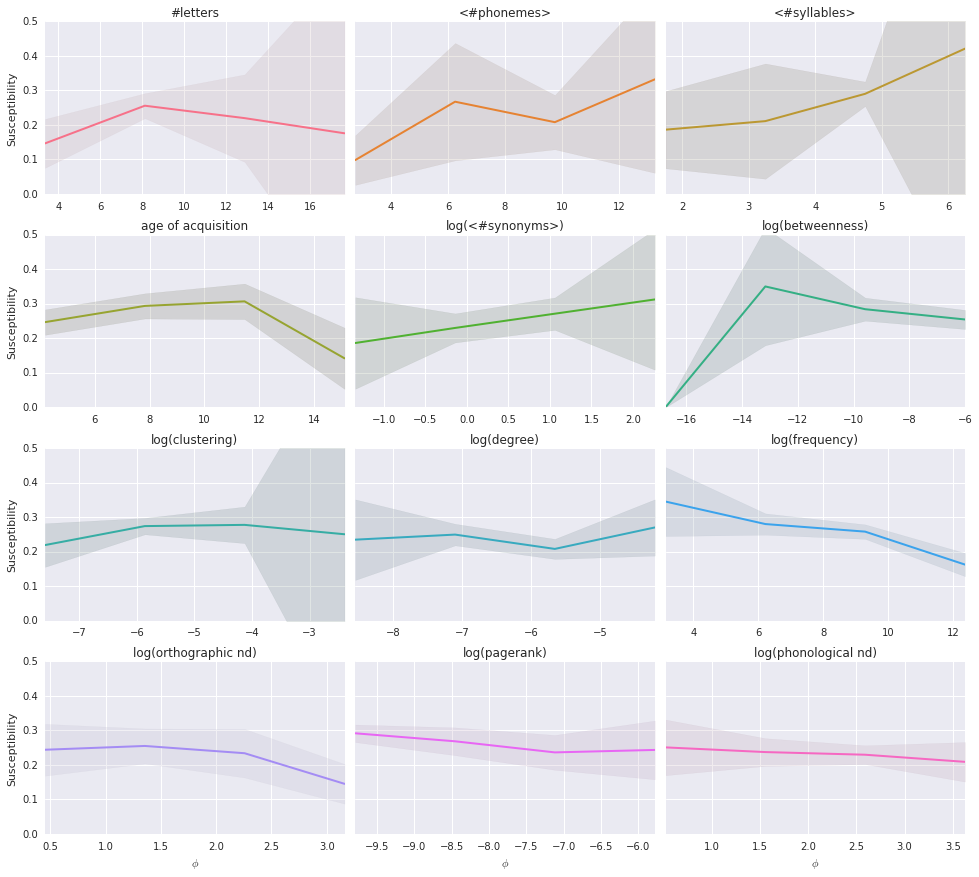

In [7]:
ordered_features = sorted(Substitution.__features__,
                          key=lambda f: Substitution._transformed_feature(f).__doc__)
g = sb.FacetGrid(data=susties, col='feature', col_wrap=3,
                 sharex=False, sharey=True, hue='feature',
                 aspect=1.5, size=3,
                 col_order=ordered_features, hue_order=ordered_features)
g.map_dataframe(plot_susties)
g.set_titles('{col_name}')
g.set_xlabels(r'$\phi$')
g.set_ylabels('Susceptibility')
for ax in g.axes.ravel():
    ax.set_title(Substitution._transformed_feature(ax.get_title()).__doc__)
if SAVE_FIGURES:
    g.fig.savefig(settings.FIGURE.format('all-feature_susceptibilities-absolute'),
                  bbox_inches='tight', dpi=300)

Now with sentence-relative values.

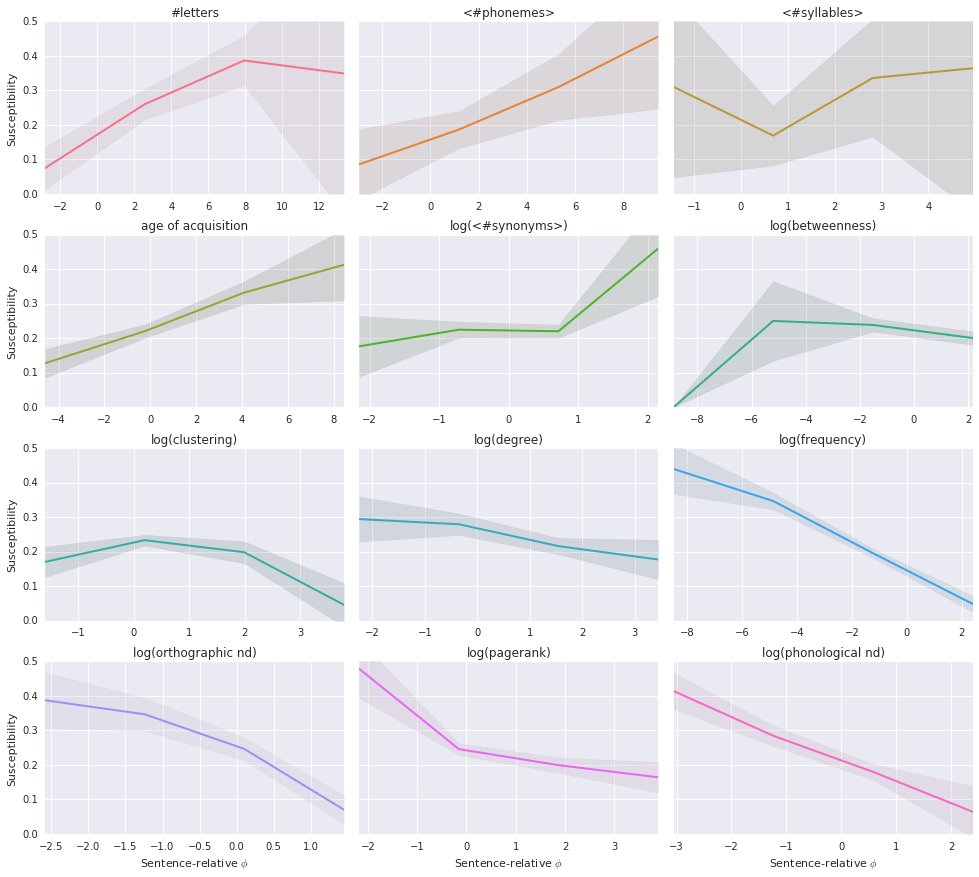

In [8]:
g = sb.FacetGrid(data=susties_rel, col='feature', col_wrap=3,
                 sharex=False, sharey=True, hue='feature',
                 aspect=1.5, size=3,
                 col_order=ordered_features, hue_order=ordered_features)
g.map_dataframe(plot_susties, relative=True)
g.set_titles('{col_name}')
g.set_xlabels(r'Sentence-relative $\phi$')
g.set_ylabels('Susceptibility')
for ax in g.axes.ravel():
    ax.set_title(Substitution._transformed_feature(ax.get_title()).__doc__)
if SAVE_FIGURES:
    g.fig.savefig(settings.FIGURE.format('all-feature_susceptibilities-relative'),
                  bbox_inches='tight', dpi=300)

**Note on how confidence intervals are computed here**

There are three ways I can conceive of the computation represented in the graphs above:
1. For each word, we look at how many times it is substituted versus how many times it appears in a position where it could have been substituted. This is the *word*'s susceptibility, $\sigma(w)$. Then for each feature bin $b_i$ we take all the words such that $\phi(w) \in b_i$, average, and compute an asymptotic confidence interval based on how many words are in the bin. This fails for sentence-relative features, because a given word has different feature values depending on the sentence it appears in. So we discard this.
2. Do the same but at the feature value level. So we define a *feature value* susceptibility, $\sigma(f)$, and compute a confidence interval based on how many different feature values we have in the bin. The idea behind (1) and (2) is to look at the bin middle-value like the relevant object we're measuring, and we have several measures for each bin middle-value, hence the confidence interval. This is the way CIs are computed above.
3. Consider that we sample a multinomial process: each substitution is in fact the sampling of a feature value from one of the four bins. In that case, we can compute multinomial proportion CIs. This is also not satisfactory since in most cases not all feature values are available at the time of sampling, since most sentences don't range over all the feature's values. So for now I'm sticking with (2).

### 2.2 Feature susceptibilities, reduced to features we expose in the paper

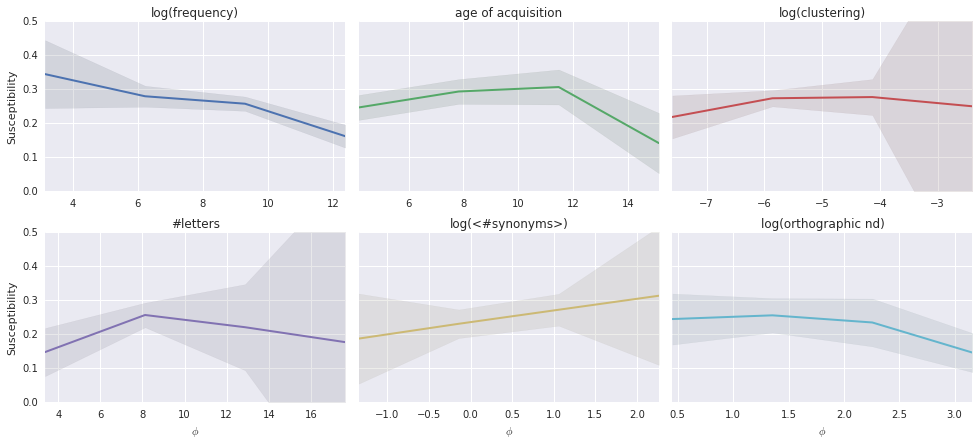

In [9]:
g = sb.FacetGrid(data=susties[susties['feature'].map(lambda f: f in PAPER_FEATURES)],
                 col='feature', col_wrap=3,
                 sharex=False, sharey=True, hue='feature',
                 aspect=1.5, size=3,
                 col_order=PAPER_FEATURES, hue_order=PAPER_FEATURES)
g.map_dataframe(plot_susties)
g.set_titles('{col_name}')
g.set_xlabels(r'$\phi$')
g.set_ylabels('Susceptibility')
for ax in g.axes.ravel():
    ax.set_title(Substitution._transformed_feature(ax.get_title()).__doc__)
if SAVE_FIGURES:
    g.fig.savefig(settings.FIGURE.format('paper-feature_susceptibilities-absolute'),
                  bbox_inches='tight', dpi=300)

Now with sentence-relative values.

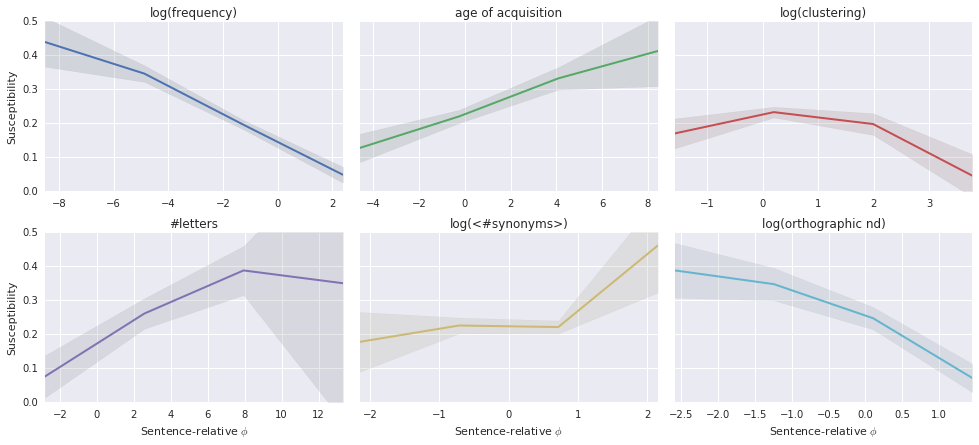

In [10]:
g = sb.FacetGrid(data=susties_rel[susties_rel['feature'].map(lambda f: f in PAPER_FEATURES)],
                 col='feature', col_wrap=3,
                 sharex=False, sharey=True, hue='feature',
                 aspect=1.5, size=3,
                 col_order=PAPER_FEATURES, hue_order=PAPER_FEATURES)
g.map_dataframe(plot_susties, relative=True)
g.set_titles('{col_name}')
g.set_xlabels(r'Sentence-relative $\phi$')
g.set_ylabels('Susceptibility')
for ax in g.axes.ravel():
    ax.set_title(Substitution._transformed_feature(ax.get_title()).__doc__)
if SAVE_FIGURES:
    g.fig.savefig(settings.FIGURE.format('paper-feature_susceptibilities-relative'),
                  bbox_inches='tight', dpi=300)

## 3 On which POS tags do substitutions fall?

In [11]:
poses = susty_words[susty_words.feature == 'aoa'][['POS', 'cluster_id', 'destination_id',
                                                   'occurrence', 'source_id', 'target',
                                                   'weight', 'weight_appeared', 'word']]
# Only take first letter of POS code to denote categories,
# and group stopword-like categories together.
stop_poses = ['C', 'F', 'I', 'M', 'P', 'S', 'U']
poses['rPOS'] = poses['POS']\
    .apply(lambda x: x[0])\
    .apply(lambda x: 'Stopword-like' if x in stop_poses else x)

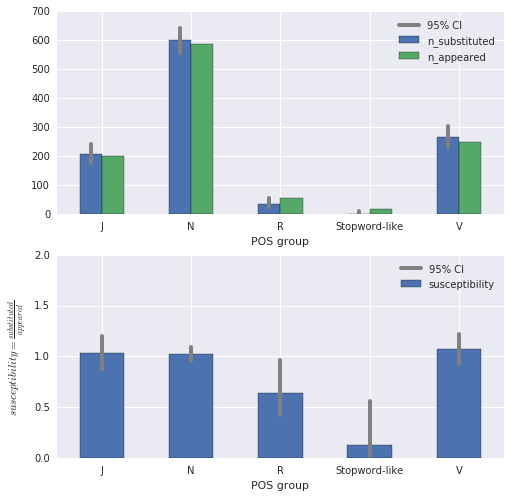

In [12]:
# Compute POS counts.
susty_pos = lambda x: ((x * poses.loc[x.index, 'weight']).sum() /
                       poses.loc[x.index, 'weight_appeared'].sum())
susties_pos = poses.groupby('rPOS')['target'].aggregate(
    {'susceptibility': susty_pos,
     'n_substituted': lambda x: (x * poses.loc[x.index, 'weight']).sum(),
     'n_appeared': lambda x: poses.loc[x.index, 'weight_appeared'].sum()}
).rename_axis('POS group')

# Plot.

fig, axes = plt.subplots(2, 1, figsize=(8, 8))
# Raw substituted and appeared values.
susties_pos[['n_substituted', 'n_appeared']].plot(ax=axes[0], kind='bar', rot=0)
# With their CIs.
total_substituted = susties_pos.n_substituted.sum()
cis = multinomial_proportions_confint(susties_pos.n_substituted.round(), method='goodman')
for i in range(len(susties_pos)):
    axes[0].plot([i-.125, i-.125], cis[i] * total_substituted, lw=4, color='grey',
                 label='95% CI' if i == 0 else None)
axes[0].legend()
# Substitutability values.
susties_pos['susceptibility'].plot(ax=axes[1], kind='bar', legend=True, ylim=(0, 2), rot=0)
axes[1].set_ylabel(r'$susceptibility = \frac{substituted}{appeared}$')
# With their CIs.
for i in range(len(susties_pos)):
    axes[1].plot([i, i], cis[i] * total_substituted / susties_pos.n_appeared.iloc[i],
                 lw=4, color='grey', label='95% CI' if i == 0 else None)
axes[1].legend(loc='best')
# Save if necessary.
if SAVE_FIGURES:
    fig.savefig(settings.FIGURE.format('all-pos_susceptibilities'),
                bbox_inches='tight', dpi=300)

**Note on confidence intervals**

Here we're in case (3) of the above explanation on confidence intervals (in section 2): it's really like a multinomial sampling, but not quite since not all POS tags are available to sample from in all the sentences. There's no way out of this, so we're going to use multinomial CIs. We can safely scale all the bars and CIs to their respective `n_appeared` values, since that is an independent given before the sampling.

**Are the appeared and substituted proportions statistically different?**

The only test we can easily do is a multinomial goodness-of-fit. This tells us if the `n_substituted` counts are significantly different from the reference `n_appeared` counts.

From there on we know a few things:
* Comparing a given POS's `n_substituted` count to its reference `n_appeared` count tells us if it's statistically different (< or >). We know this will be true individually for any POS that is out of its confidence region for the global goodness-of-fit test, since it's a weaker hypothesis (so the null rejection region will be wider, and the POS we're looking at is already in the rejection region for the global test). We don't know if it'll be true or not for POSes that are in their confidence region for the global test.
* Jointly comparing two POS's `n_substituted` counts to their reference `n_appeared` counts tells us if there is bias for one w.r.t. the other. This is also true for all pairs of POSes that are on alternate sides of their confidence region in the global test (for the same reasons as in the previous point). We don't know if it's true for the other POSes though.

In [13]:
# Test the n_substituted proportions are different from the n_appeared proportions
total_appeared = susties_pos.n_appeared.sum()
appeared_cis = multinomial_proportions_confint(susties_pos.n_appeared.round(), method='goodman')
differences = [(s < ci[0] * total_appeared) or (s > ci[1] * total_appeared)
               for s, ci in zip(susties_pos.n_substituted, appeared_cis)]
are_different = np.any(differences)
if are_different:
    print("Appeared and substituted proportions are different with p < .05")
    print("The following POS tags are out of their confidence region:",
          list(susties_pos.index[np.where(differences)[0]]))
else:
    print("Appeared and substituted proportions cannot be "
          "said different with p value better than .05")

Appeared and substituted proportions are different with p < .05
The following POS tags are out of their confidence region: ['R', 'Stopword-like']


## 4 Susceptibility in terms of absolute fractiles

In [14]:
def plot_absolute_fractile_distribution(**kwargs):
    data = kwargs['data']
    color = kwargs.get('color', 'blue')

    # Compute feature bins.
    for bin_count in range(BIN_COUNT, 0, -1):
        try:
            x_fractiles = pd.qcut(data.value, bin_count, labels=False)
            break
        except ValueError:
            pass

    # Compute bin counts
    heights = np.zeros(bin_count)
    for i in range(bin_count):
        heights[i] = data[data.target & (x_fractiles == i)].weight.sum()
    total = sum(heights)
    cis = multinomial_proportions_confint(heights.round(), method='goodman') * total
    
    # Plot them.
    plt.plot(range(1, bin_count + 1), heights, color=color)
    plt.fill_between(range(1, bin_count + 1), cis[:, 0], cis[:, 1],
                     color=sb.desaturate(color, 0.2), alpha=0.2)
    plt.xticks(range(1, bin_count + 1))
    plt.xlim(1, bin_count)
    plt.ylim(0, None)

### 4.1 All features susceptibilities

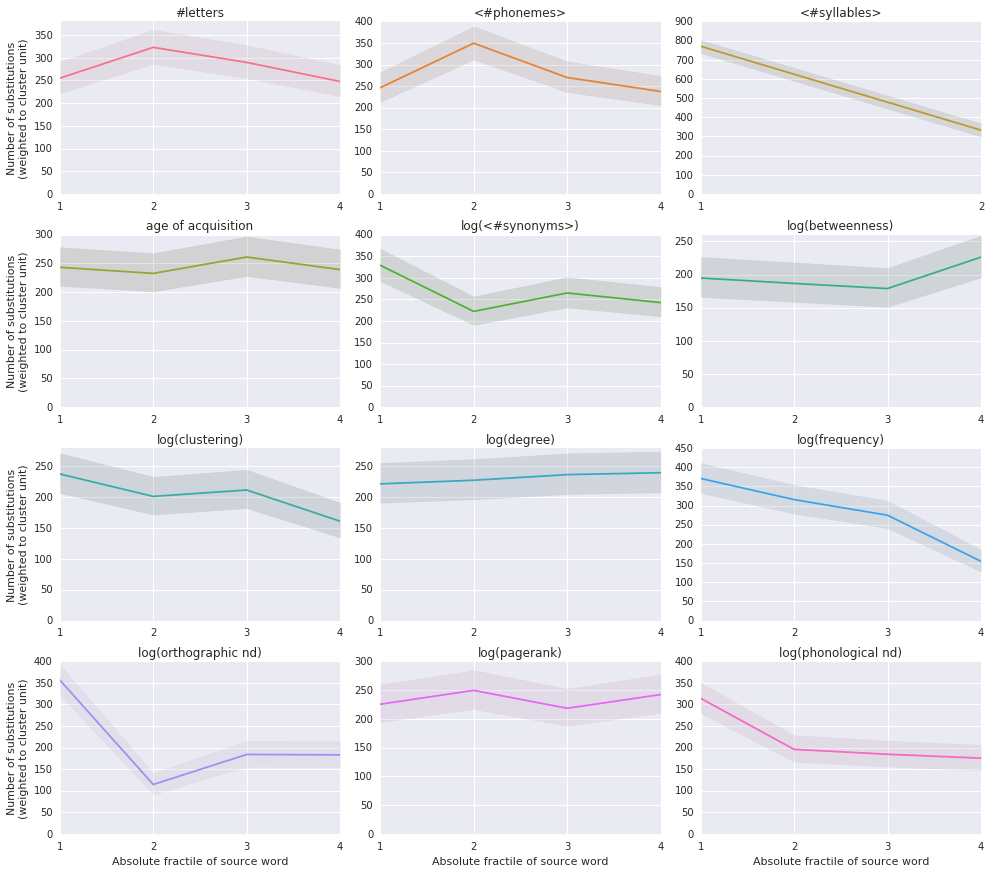

In [15]:
# Now plot.
g = sb.FacetGrid(data=susty_words, col='feature', col_wrap=3,
                 sharex=False, sharey=False, hue='feature',
                 aspect=1.5, size=3,
                 col_order=ordered_features, hue_order=ordered_features)
g.map_dataframe(plot_absolute_fractile_distribution)
g.set_titles('{col_name}')
g.set_xlabels('Absolute fractile of source word')
g.set_ylabels('Number of substitutions\n(weighted to cluster unit)')
for ax in g.axes.ravel():
    ax.set_title(Substitution._transformed_feature(ax.get_title()).__doc__)
if SAVE_FIGURES:
    g.fig.savefig(settings.FIGURE.format('all-fractile_susceptibilities-absolute'),
                  bbox_inches='tight', dpi=300)

**Note on confidence intervals**

Here we're again in case (3) of the above explanation on confidence intervals (in section 2): it's really like a multinomial sampling, but not quite since not all absolute feature fractiles are available to sample from in all the sentences. Again, there's no way out of this, so we're going to use multinomial CIs.

### 4.2 Feature susceptibilities, reduced to features we expose in the paper

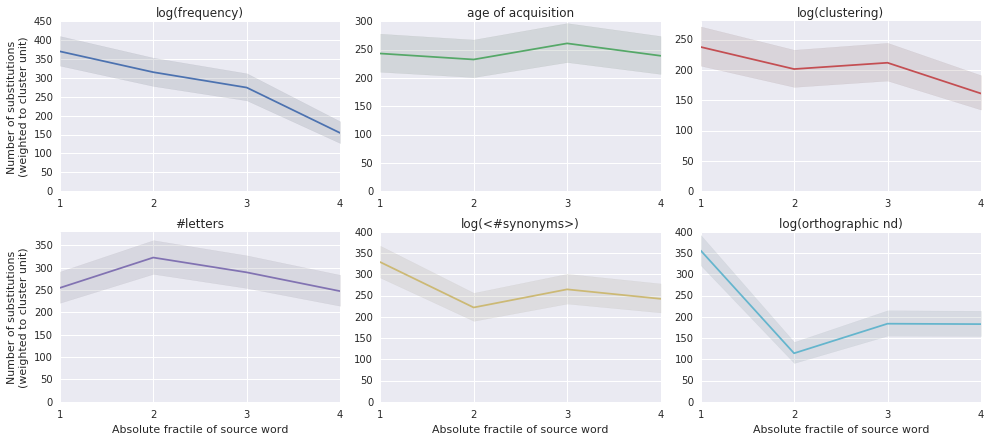

In [16]:
# Now plot.
g = sb.FacetGrid(data=susty_words[susty_words['feature'].map(lambda f: f in PAPER_FEATURES)],
                 col='feature', col_wrap=3,
                 sharex=False, sharey=False, hue='feature',
                 aspect=1.5, size=3,
                 col_order=PAPER_FEATURES, hue_order=PAPER_FEATURES)
g.map_dataframe(plot_absolute_fractile_distribution)
g.set_titles('{col_name}')
g.set_xlabels('Absolute fractile of source word')
g.set_ylabels('Number of substitutions\n(weighted to cluster unit)')
for ax in g.axes.ravel():
    ax.set_title(Substitution._transformed_feature(ax.get_title()).__doc__)
if SAVE_FIGURES:
    g.fig.savefig(settings.FIGURE.format('paper-fractile_susceptibilities-absolute'),
                  bbox_inches='tight', dpi=300)

## 5 Susceptibility in terms of sentence fractiles

Build our data.

In [17]:
data = []
for substitution_id in ProgressBar(term_width=80)(substitution_ids):
    with session_scope() as session:
        substitution = session.query(Substitution).get(substitution_id)
        
        for feature in Substitution.__features__:
            source, _ = substitution.features(feature)
            if np.isnan(source):
                # The source word has no feature value. We drop this substitution.
                continue
            sentence, _ = substitution.source_destination_features(feature)
            # Remove stopwords from this analysis, since we dropped substitutions on stopwords.
            dslice = slice(substitution.start,
                           substitution.start + len(substitution.destination.tokens))
            is_stopword = np.array([(lemma in stopwords) or (token in stopwords)
                                    for (lemma, token) in
                                    zip(substitution.source.lemmas[dslice],
                                        substitution.source.tokens[dslice])])
            sentence[is_stopword] = np.nan
            # Find the number of bins we'll use.
            values = set(sentence[np.isfinite(sentence)])
            if len(values) == 0 or len(values) == 1:
                # Only NaNs, or only one feature value. Drop this.
                continue
            start, stop = None, None
            power = 0
            while start is None:
                if int(BIN_COUNT / 2**power) * 2**power != BIN_COUNT:
                    raise ValueError('BIN_COUNT must be a power of 2')
                try:
                    start = 2**power * pd.qcut(sentence, int(BIN_COUNT / 2**power),
                                               labels=False)[substitution.position]
                    stop = start + 2**power
                except ValueError:
                    power += 1
            # And finally save the bin.
            data.append({'cluster_id': substitution.source.cluster.sid,
                         'destination_id': substitution.destination.sid,
                         'occurrence': substitution.occurrence,
                         'source_id': substitution.source.sid,
                         'feature': feature,
                         'start': start,
                         'stop': stop})

original_fractiles = pd.DataFrame(data)
del data

  0% (   81 of 15119) |                    | Elapsed Time: 0:00:01 ETA:  0:03:06

  1% (  189 of 15119) |                    | Elapsed Time: 0:00:02 ETA:  0:02:39

  1% (  273 of 15119) |                    | Elapsed Time: 0:00:03 ETA:  0:02:46

  2% (  378 of 15119) |                    | Elapsed Time: 0:00:04 ETA:  0:02:40

  3% (  458 of 15119) |                    | Elapsed Time: 0:00:05 ETA:  0:02:45

  3% (  567 of 15119) |                    | Elapsed Time: 0:00:06 ETA:  0:02:38

  4% (  656 of 15119) |                    | Elapsed Time: 0:00:07 ETA:  0:02:38

  4% (  726 of 15119) |                    | Elapsed Time: 0:00:08 ETA:  0:02:44

  5% (  756 of 15119) |#                   | Elapsed Time: 0:00:08 ETA:  0:02:47

  5% (  822 of 15119) |#                   | Elapsed Time: 0:00:09 ETA:  0:02:52

  5% (  892 of 15119) |#                   | Elapsed Time: 0:00:10 ETA:  0:03:01

  6% (  945 of 15119) |#                   | Elapsed Time: 0:00:11 ETA:  0:03:04

  6% ( 1017 of 15119) |#                   | Elapsed Time: 0:00:12 ETA:  0:03:06

  7% ( 1076 of 15119) |#                   | Elapsed Time: 0:00:13 ETA:  0:03:23

  7% ( 1134 of 15119) |#                   | Elapsed Time: 0:00:14 ETA:  0:03:23

  7% ( 1193 of 15119) |#                   | Elapsed Time: 0:00:15 ETA:  0:03:34

  8% ( 1262 of 15119) |#                   | Elapsed Time: 0:00:16 ETA:  0:03:34

  8% ( 1323 of 15119) |#                   | Elapsed Time: 0:00:17 ETA:  0:03:32

  9% ( 1391 of 15119) |#                   | Elapsed Time: 0:00:18 ETA:  0:03:30

  9% ( 1453 of 15119) |#                   | Elapsed Time: 0:00:19 ETA:  0:03:32

 10% ( 1512 of 15119) |##                  | Elapsed Time: 0:00:20 ETA:  0:03:32

 10% ( 1587 of 15119) |##                  | Elapsed Time: 0:00:21 ETA:  0:03:30

 11% ( 1666 of 15119) |##                  | Elapsed Time: 0:00:22 ETA:  0:03:21

 11% ( 1701 of 15119) |##                  | Elapsed Time: 0:00:22 ETA:  0:03:18

 11% ( 1784 of 15119) |##                  | Elapsed Time: 0:00:23 ETA:  0:03:08

 12% ( 1870 of 15119) |##                  | Elapsed Time: 0:00:24 ETA:  0:03:01

 12% ( 1890 of 15119) |##                  | Elapsed Time: 0:00:25 ETA:  0:02:58

 13% ( 1975 of 15119) |##                  | Elapsed Time: 0:00:26 ETA:  0:02:51

 13% ( 2054 of 15119) |##                  | Elapsed Time: 0:00:27 ETA:  0:02:44

 13% ( 2079 of 15119) |##                  | Elapsed Time: 0:00:27 ETA:  0:02:40

 14% ( 2146 of 15119) |##                  | Elapsed Time: 0:00:28 ETA:  0:02:41

 14% ( 2211 of 15119) |##                  | Elapsed Time: 0:00:29 ETA:  0:02:45

 15% ( 2268 of 15119) |###                 | Elapsed Time: 0:00:30 ETA:  0:02:47

 15% ( 2335 of 15119) |###                 | Elapsed Time: 0:00:31 ETA:  0:02:52

 16% ( 2422 of 15119) |###                 | Elapsed Time: 0:00:32 ETA:  0:02:50

 16% ( 2457 of 15119) |###                 | Elapsed Time: 0:00:32 ETA:  0:02:50

 16% ( 2533 of 15119) |###                 | Elapsed Time: 0:00:33 ETA:  0:02:52

 17% ( 2605 of 15119) |###                 | Elapsed Time: 0:00:34 ETA:  0:02:54

 17% ( 2646 of 15119) |###                 | Elapsed Time: 0:00:35 ETA:  0:02:53

 17% ( 2719 of 15119) |###                 | Elapsed Time: 0:00:36 ETA:  0:02:50

 18% ( 2805 of 15119) |###                 | Elapsed Time: 0:00:37 ETA:  0:02:42

 18% ( 2835 of 15119) |###                 | Elapsed Time: 0:00:37 ETA:  0:02:41

 19% ( 2900 of 15119) |###                 | Elapsed Time: 0:00:38 ETA:  0:02:41

 19% ( 2964 of 15119) |###                 | Elapsed Time: 0:00:39 ETA:  0:02:48

 20% ( 3024 of 15119) |####                | Elapsed Time: 0:00:40 ETA:  0:02:49

 20% ( 3104 of 15119) |####                | Elapsed Time: 0:00:41 ETA:  0:02:47

 21% ( 3188 of 15119) |####                | Elapsed Time: 0:00:42 ETA:  0:02:41

 21% ( 3213 of 15119) |####                | Elapsed Time: 0:00:42 ETA:  0:02:40

 22% ( 3327 of 15119) |####                | Elapsed Time: 0:00:43 ETA:  0:02:25

 22% ( 3402 of 15119) |####                | Elapsed Time: 0:00:44 ETA:  0:02:22

 23% ( 3505 of 15119) |####                | Elapsed Time: 0:00:45 ETA:  0:02:14

 23% ( 3591 of 15119) |####                | Elapsed Time: 0:00:46 ETA:  0:02:04

 24% ( 3694 of 15119) |####                | Elapsed Time: 0:00:47 ETA:  0:01:54

 25% ( 3780 of 15119) |#####               | Elapsed Time: 0:00:48 ETA:  0:01:50

 25% ( 3866 of 15119) |#####               | Elapsed Time: 0:00:49 ETA:  0:01:49

 26% ( 3969 of 15119) |#####               | Elapsed Time: 0:00:50 ETA:  0:01:54

 26% ( 4049 of 15119) |#####               | Elapsed Time: 0:00:51 ETA:  0:01:57

 27% ( 4158 of 15119) |#####               | Elapsed Time: 0:00:53 ETA:  0:02:01

 28% ( 4246 of 15119) |#####               | Elapsed Time: 0:00:54 ETA:  0:02:05

 28% ( 4322 of 15119) |#####               | Elapsed Time: 0:00:55 ETA:  0:02:03

 28% ( 4347 of 15119) |#####               | Elapsed Time: 0:00:55 ETA:  0:02:04

 29% ( 4428 of 15119) |#####               | Elapsed Time: 0:00:56 ETA:  0:02:04

 29% ( 4508 of 15119) |#####               | Elapsed Time: 0:00:57 ETA:  0:02:05

 30% ( 4536 of 15119) |######              | Elapsed Time: 0:00:58 ETA:  0:02:36

 30% ( 4660 of 15119) |######              | Elapsed Time: 0:00:59 ETA:  0:02:23

 31% ( 4725 of 15119) |######              | Elapsed Time: 0:01:00 ETA:  0:02:19

 31% ( 4821 of 15119) |######              | Elapsed Time: 0:01:01 ETA:  0:02:16

 32% ( 4914 of 15119) |######              | Elapsed Time: 0:01:02 ETA:  0:02:09

 33% ( 5004 of 15119) |######              | Elapsed Time: 0:01:03 ETA:  0:02:05

 33% ( 5077 of 15119) |######              | Elapsed Time: 0:01:04 ETA:  0:02:07

 33% ( 5103 of 15119) |######              | Elapsed Time: 0:01:04 ETA:  0:01:38

 34% ( 5189 of 15119) |######              | Elapsed Time: 0:01:05 ETA:  0:01:39

 35% ( 5292 of 15119) |#######             | Elapsed Time: 0:01:07 ETA:  0:01:47

 35% ( 5369 of 15119) |#######             | Elapsed Time: 0:01:08 ETA:  0:01:52

 36% ( 5481 of 15119) |#######             | Elapsed Time: 0:01:09 ETA:  0:01:48

 36% ( 5579 of 15119) |#######             | Elapsed Time: 0:01:10 ETA:  0:01:45

 37% ( 5670 of 15119) |#######             | Elapsed Time: 0:01:11 ETA:  0:01:39

 38% ( 5761 of 15119) |#######             | Elapsed Time: 0:01:12 ETA:  0:01:37

 38% ( 5843 of 15119) |#######             | Elapsed Time: 0:01:13 ETA:  0:01:38

 38% ( 5859 of 15119) |#######             | Elapsed Time: 0:01:13 ETA:  0:01:39

 39% ( 5954 of 15119) |#######             | Elapsed Time: 0:01:14 ETA:  0:01:32

 40% ( 6048 of 15119) |########            | Elapsed Time: 0:01:15 ETA:  0:01:30

 40% ( 6152 of 15119) |########            | Elapsed Time: 0:01:16 ETA:  0:01:28

 41% ( 6237 of 15119) |########            | Elapsed Time: 0:01:17 ETA:  0:01:26

 41% ( 6337 of 15119) |########            | Elapsed Time: 0:01:18 ETA:  0:01:22

 42% ( 6426 of 15119) |########            | Elapsed Time: 0:01:19 ETA:  0:01:20

 43% ( 6524 of 15119) |########            | Elapsed Time: 0:01:20 ETA:  0:01:17

 43% ( 6615 of 15119) |########            | Elapsed Time: 0:01:21 ETA:  0:01:10

 44% ( 6689 of 15119) |########            | Elapsed Time: 0:01:22 ETA:  0:01:13

 44% ( 6778 of 15119) |########            | Elapsed Time: 0:01:23 ETA:  0:01:13

 45% ( 6804 of 15119) |#########           | Elapsed Time: 0:01:23 ETA:  0:01:14

 45% ( 6919 of 15119) |#########           | Elapsed Time: 0:01:24 ETA:  0:01:10

 46% ( 6993 of 15119) |#########           | Elapsed Time: 0:01:25 ETA:  0:01:10

 46% ( 7085 of 15119) |#########           | Elapsed Time: 0:01:26 ETA:  0:01:11

 47% ( 7182 of 15119) |#########           | Elapsed Time: 0:01:27 ETA:  0:01:13

 48% ( 7279 of 15119) |#########           | Elapsed Time: 0:01:28 ETA:  0:01:15

 48% ( 7371 of 15119) |#########           | Elapsed Time: 0:01:29 ETA:  0:01:10

 49% ( 7449 of 15119) |#########           | Elapsed Time: 0:01:30 ETA:  0:01:13

 49% ( 7526 of 15119) |#########           | Elapsed Time: 0:01:31 ETA:  0:01:22

 50% ( 7560 of 15119) |##########          | Elapsed Time: 0:01:31 ETA:  0:01:24

 50% ( 7641 of 15119) |##########          | Elapsed Time: 0:01:32 ETA:  0:01:27

 51% ( 7728 of 15119) |##########          | Elapsed Time: 0:01:33 ETA:  0:01:27

 51% ( 7749 of 15119) |##########          | Elapsed Time: 0:01:34 ETA:  0:01:26

 51% ( 7834 of 15119) |##########          | Elapsed Time: 0:01:35 ETA:  0:01:29

 52% ( 7910 of 15119) |##########          | Elapsed Time: 0:01:36 ETA:  0:01:32

 52% ( 7938 of 15119) |##########          | Elapsed Time: 0:01:36 ETA:  0:01:33

 53% ( 8024 of 15119) |##########          | Elapsed Time: 0:01:37 ETA:  0:01:29

 53% ( 8127 of 15119) |##########          | Elapsed Time: 0:01:38 ETA:  0:01:24

 54% ( 8211 of 15119) |##########          | Elapsed Time: 0:01:39 ETA:  0:01:22

 54% ( 8297 of 15119) |##########          | Elapsed Time: 0:01:40 ETA:  0:01:21

 55% ( 8316 of 15119) |###########         | Elapsed Time: 0:01:40 ETA:  0:01:21

 55% ( 8389 of 15119) |###########         | Elapsed Time: 0:01:41 ETA:  0:01:24

 56% ( 8470 of 15119) |###########         | Elapsed Time: 0:01:42 ETA:  0:01:22

 56% ( 8505 of 15119) |###########         | Elapsed Time: 0:01:43 ETA:  0:01:20

 56% ( 8585 of 15119) |###########         | Elapsed Time: 0:01:44 ETA:  0:01:22

 57% ( 8663 of 15119) |###########         | Elapsed Time: 0:01:45 ETA:  0:01:22

 57% ( 8694 of 15119) |###########         | Elapsed Time: 0:01:45 ETA:  0:01:25

 58% ( 8776 of 15119) |###########         | Elapsed Time: 0:01:46 ETA:  0:01:25

 58% ( 8859 of 15119) |###########         | Elapsed Time: 0:01:47 ETA:  0:01:25

 58% ( 8883 of 15119) |###########         | Elapsed Time: 0:01:48 ETA:  0:01:26

 59% ( 8964 of 15119) |###########         | Elapsed Time: 0:01:49 ETA:  0:01:23

 60% ( 9072 of 15119) |############        | Elapsed Time: 0:01:50 ETA:  0:01:13

 60% ( 9170 of 15119) |############        | Elapsed Time: 0:01:51 ETA:  0:01:06

 61% ( 9261 of 15119) |############        | Elapsed Time: 0:01:52 ETA:  0:00:57

 61% ( 9355 of 15119) |############        | Elapsed Time: 0:01:53 ETA:  0:00:53

 62% ( 9450 of 15119) |############        | Elapsed Time: 0:01:54 ETA:  0:00:47

 63% ( 9535 of 15119) |############        | Elapsed Time: 0:01:55 ETA:  0:00:45

 63% ( 9639 of 15119) |############        | Elapsed Time: 0:01:56 ETA:  0:00:46

 64% ( 9716 of 15119) |############        | Elapsed Time: 0:01:57 ETA:  0:00:49

 64% ( 9804 of 15119) |############        | Elapsed Time: 0:01:58 ETA:  0:00:50

 65% ( 9828 of 15119) |#############       | Elapsed Time: 0:01:58 ETA:  0:00:55

 65% ( 9935 of 15119) |#############       | Elapsed Time: 0:01:59 ETA:  0:00:50

 66% (10017 of 15119) |#############       | Elapsed Time: 0:02:00 ETA:  0:00:53

 66% (10105 of 15119) |#############       | Elapsed Time: 0:02:01 ETA:  0:00:51

 67% (10206 of 15119) |#############       | Elapsed Time: 0:02:02 ETA:  0:00:43

 68% (10294 of 15119) |#############       | Elapsed Time: 0:02:03 ETA:  0:00:44

 68% (10395 of 15119) |#############       | Elapsed Time: 0:02:04 ETA:  0:00:37

 69% (10488 of 15119) |#############       | Elapsed Time: 0:02:05 ETA:  0:00:36

 70% (10584 of 15119) |##############      | Elapsed Time: 0:02:06 ETA:  0:00:35

 70% (10665 of 15119) |##############      | Elapsed Time: 0:02:07 ETA:  0:00:37

 71% (10748 of 15119) |##############      | Elapsed Time: 0:02:08 ETA:  0:00:38

 71% (10773 of 15119) |##############      | Elapsed Time: 0:02:09 ETA:  0:00:43

 71% (10853 of 15119) |##############      | Elapsed Time: 0:02:10 ETA:  0:00:44

 72% (10962 of 15119) |##############      | Elapsed Time: 0:02:11 ETA:  0:00:43

 73% (11066 of 15119) |##############      | Elapsed Time: 0:02:12 ETA:  0:00:39

 73% (11151 of 15119) |##############      | Elapsed Time: 0:02:13 ETA:  0:00:34

 74% (11238 of 15119) |##############      | Elapsed Time: 0:02:14 ETA:  0:00:34

 75% (11340 of 15119) |###############     | Elapsed Time: 0:02:15 ETA:  0:00:29

 75% (11455 of 15119) |###############     | Elapsed Time: 0:02:16 ETA:  0:00:22

 76% (11529 of 15119) |###############     | Elapsed Time: 0:02:17 ETA:  0:00:17

 76% (11622 of 15119) |###############     | Elapsed Time: 0:02:18 ETA:  0:00:15

 76% (11630 of 15119) |###############     | Elapsed Time: 0:02:19 ETA:  0:00:41

 77% (11718 of 15119) |###############     | Elapsed Time: 0:02:20 ETA:  0:00:53

 78% (11811 of 15119) |###############     | Elapsed Time: 0:02:21 ETA:  0:00:50

 78% (11907 of 15119) |###############     | Elapsed Time: 0:02:22 ETA:  0:00:49

 79% (11994 of 15119) |###############     | Elapsed Time: 0:02:23 ETA:  0:00:58

 80% (12096 of 15119) |################    | Elapsed Time: 0:02:24 ETA:  0:01:06

 80% (12180 of 15119) |################    | Elapsed Time: 0:02:25 ETA:  0:00:28

 81% (12285 of 15119) |################    | Elapsed Time: 0:02:26 ETA:  0:00:25

 81% (12370 of 15119) |################    | Elapsed Time: 0:02:27 ETA:  0:00:27

 82% (12474 of 15119) |################    | Elapsed Time: 0:02:29 ETA:  0:00:24

 83% (12555 of 15119) |################    | Elapsed Time: 0:02:30 ETA:  0:00:25

 83% (12634 of 15119) |################    | Elapsed Time: 0:02:31 ETA:  0:00:28

 83% (12663 of 15119) |################    | Elapsed Time: 0:02:31 ETA:  0:00:28

 84% (12744 of 15119) |################    | Elapsed Time: 0:02:32 ETA:  0:00:28

 84% (12820 of 15119) |################    | Elapsed Time: 0:02:33 ETA:  0:00:31

 85% (12852 of 15119) |#################   | Elapsed Time: 0:02:33 ETA:  0:00:29

 85% (12948 of 15119) |#################   | Elapsed Time: 0:02:34 ETA:  0:00:25

 86% (13041 of 15119) |#################   | Elapsed Time: 0:02:35 ETA:  0:00:28

 86% (13121 of 15119) |#################   | Elapsed Time: 0:02:36 ETA:  0:00:27

 87% (13208 of 15119) |#################   | Elapsed Time: 0:02:37 ETA:  0:00:24

 87% (13230 of 15119) |#################   | Elapsed Time: 0:02:38 ETA:  0:00:24

 88% (13329 of 15119) |#################   | Elapsed Time: 0:02:39 ETA:  0:00:17

 88% (13419 of 15119) |#################   | Elapsed Time: 0:02:40 ETA:  0:00:13

 89% (13509 of 15119) |#################   | Elapsed Time: 0:02:41 ETA:  0:00:14

 90% (13608 of 15119) |##################  | Elapsed Time: 0:02:42 ETA:  0:00:10

 90% (13701 of 15119) |##################  | Elapsed Time: 0:02:43 ETA:  0:00:05

 91% (13797 of 15119) |##################  | Elapsed Time: 0:02:44 ETA:  0:00:01

 91% (13896 of 15119) |##################  | Elapsed Time: 0:02:45 ETA:  0:00:00

 92% (13986 of 15119) |##################  | Elapsed Time: 0:02:46 ETA:  0:00:01

 93% (14070 of 15119) |##################  | Elapsed Time: 0:02:47 ETA:  0:00:02

 93% (14175 of 15119) |##################  | Elapsed Time: 0:02:48 ETA:  0:00:00

 94% (14270 of 15119) |##################  | Elapsed Time: 0:02:49 ETA:  0:00:00

 95% (14364 of 15119) |################### | Elapsed Time: 0:02:50 ETA:  0:00:00

 95% (14452 of 15119) |################### | Elapsed Time: 0:02:51 ETA:  0:00:00

 96% (14553 of 15119) |################### | Elapsed Time: 0:02:52 ETA:  0:00:00

 96% (14630 of 15119) |################### | Elapsed Time: 0:02:53 ETA:  0:00:00

 97% (14714 of 15119) |################### | Elapsed Time: 0:02:54 ETA:  0:00:00

 97% (14742 of 15119) |################### | Elapsed Time: 0:02:55 ETA:  0:00:00

 98% (14837 of 15119) |################### | Elapsed Time: 0:02:56 ETA:  0:00:00

 98% (14931 of 15119) |################### | Elapsed Time: 0:02:57 ETA:  0:00:00

 99% (15026 of 15119) |################### | Elapsed Time: 0:02:58 ETA:  0:00:00

100% (15119 of 15119) |####################| Elapsed Time: 0:02:59 Time: 0:02:59


Compute the weight of each substitution, according to what other substitutions it's pooled with, and the size of its bin. Letting:
* $n_d(i) = \#\text{substitutions with same durl as substitution }i$
* and $n_c(i) = \#\text{substitutions with same cluster as substitution }i$ (counting substitutions with the same durl as one)
* $p(i) = \text{precision (width) of the bin we assigned to substitution }i$

Then we define the weight of a substitution $i$:
$$w(i) = \frac{1}{n_d(i) n_c(i) p(i)}$$

In [18]:
fractiles = original_fractiles.copy()
divide_sum = lambda x: x / x.sum()

# Weight is 1 at first.
fractiles['weight'] = 1
# Divided by the number of substitutions that share a durl.
fractiles['weight'] = fractiles\
    .groupby(['destination_id', 'occurrence', 'feature'])['weight']\
    .transform(divide_sum)
# Divided by the number of substitutions that share a cluster. (Using divide_sum,
# where we divide by the sum of weights, ensures we count only one for each group
# of substitutions sharing a same durl.)
fractiles['weight'] = fractiles\
    .groupby(['cluster_id', 'feature'])['weight']\
    .transform(divide_sum)
# And finally divide by the precision of the bin we put a substitution in.
fractiles['weight'] = fractiles['weight'] / (fractiles['stop'] - fractiles['start'])

Now for each feature, count the sum of weights in each bin and plot that.

In [19]:
def plot_fractile_distribution(**kwargs):
    data = kwargs['data']
    color = kwargs.get('color', 'blue')
    
    # Compute bin counts
    heights = np.zeros(BIN_COUNT)
    for i in range(BIN_COUNT):
        heights[i] = data[(data['start'] <= i) & (i < data['stop'])]['weight'].sum()
    total = sum(heights)
    cis = multinomial_proportions_confint(heights.round(), method='goodman') * total
    
    # Plot them.
    plt.plot(range(1, BIN_COUNT + 1), heights, color=color)
    plt.fill_between(range(1, BIN_COUNT + 1), cis[:, 0], cis[:, 1],
                     color=sb.desaturate(color, 0.2), alpha=0.2)
    plt.xticks(range(1, BIN_COUNT + 1))
    plt.ylim(0, None)

### 5.1 All features susceptibilities

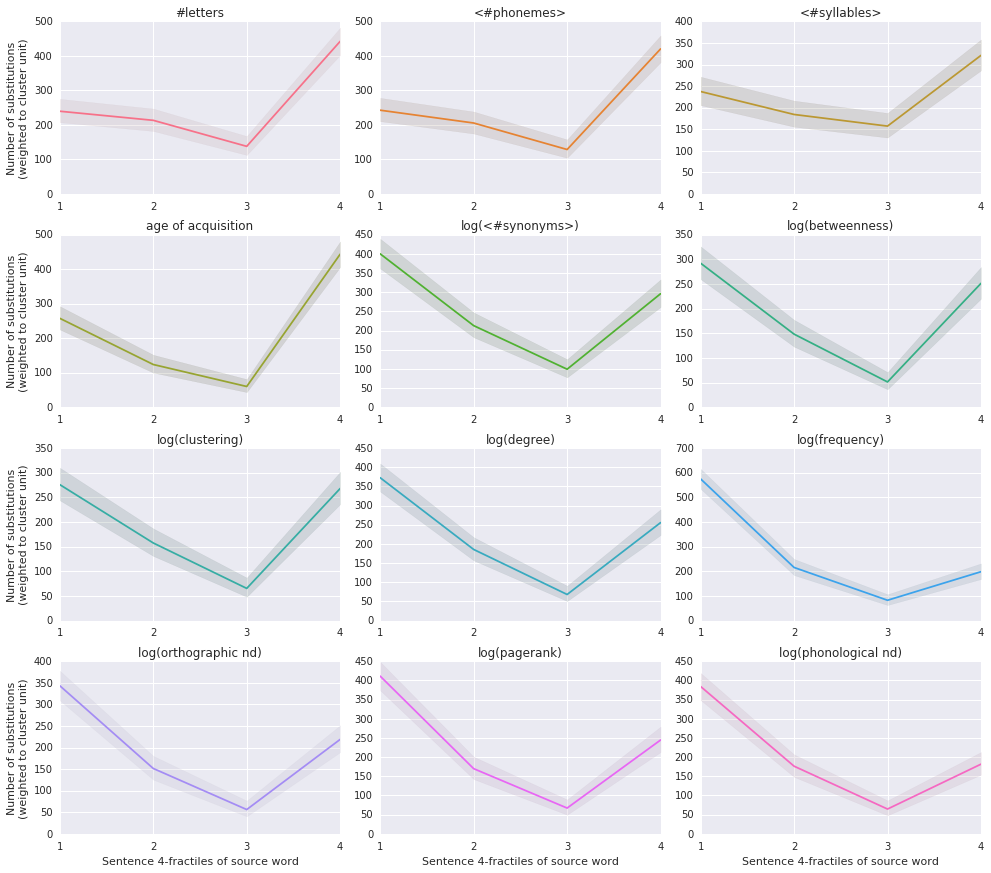

In [20]:
# Now plot.
g = sb.FacetGrid(data=fractiles, col='feature', col_wrap=3,
                 sharex=False, sharey=False, hue='feature',
                 aspect=1.5, size=3,
                 col_order=ordered_features, hue_order=ordered_features)
g.map_dataframe(plot_fractile_distribution)
g.set_titles('{col_name}')
g.set_xlabels('Sentence {}-fractiles of source word'.format(BIN_COUNT))
g.set_ylabels('Number of substitutions\n(weighted to cluster unit)')
for ax in g.axes.ravel():
    ax.set_title(Substitution._transformed_feature(ax.get_title()).__doc__)
if SAVE_FIGURES:
    g.fig.savefig(settings.FIGURE.format('all-fractile_susceptibilities-relative'),
                  bbox_inches='tight', dpi=300)

**Note on confidence intervals**

Here we're finally in a real multinomial sampling (and it's the only time). So we're going to use multinomial CIs.

### 5.2 Feature susceptibilities, reduced to features we expose in the paper

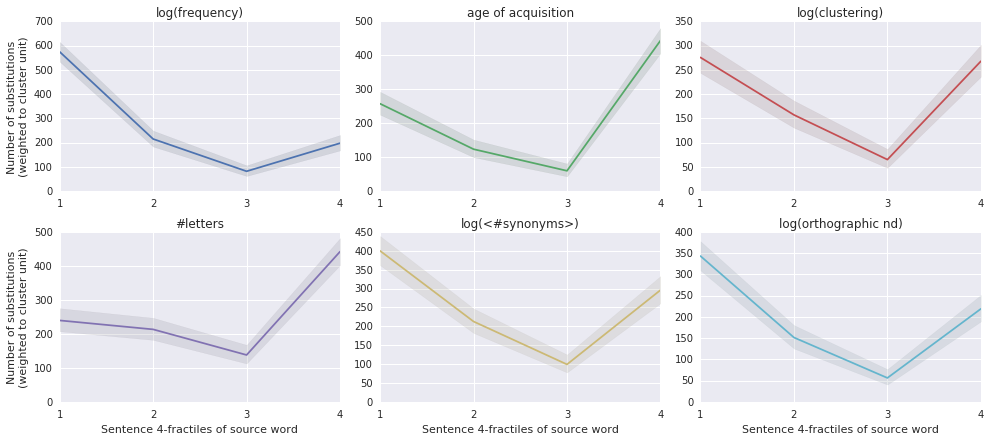

In [21]:
# Now plot.
g = sb.FacetGrid(data=fractiles[fractiles['feature'].map(lambda f: f in PAPER_FEATURES)],
                 col='feature', col_wrap=3,
                 sharex=False, sharey=False, hue='feature',
                 aspect=1.5, size=3,
                 col_order=PAPER_FEATURES, hue_order=PAPER_FEATURES)
g.map_dataframe(plot_fractile_distribution)
g.set_titles('{col_name}')
g.set_xlabels('Sentence {}-fractiles of source word'.format(BIN_COUNT))
g.set_ylabels('Number of substitutions\n(weighted to cluster unit)')
for ax in g.axes.ravel():
    ax.set_title(Substitution._transformed_feature(ax.get_title()).__doc__)
if SAVE_FIGURES:
    g.fig.savefig(settings.FIGURE.format('paper-fractile_susceptibilities-relative'),
                  bbox_inches='tight', dpi=300)